## *Imports and Installs*

In [ ]:
!pip install gensim
!pip install Unidecode
!pip install ml_metrics
!pip install sklearn_evaluation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import multiprocessing
import pickle as pk
import logging  # Setting up the loggings to monitor gensim
import nltk
import seaborn as sb
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('words')

from keras.models import Sequential 
from nltk.corpus import stopwords
from collections import defaultdict
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords
from gensim import utils
from os import listdir
from os.path import isfile, join
from unidecode import unidecode
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE



# import logging, sys
# logging.disable(sys.maxsize)
# logging.getLogger("imported_module").setLevel(logging.WARNING)
# logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


## *Reusable Functions*

In [ ]:
# ******** Reusable Functions ******** 

# Serializing dataframes into Objects (for space and fast accesibility)
def serialize(path,data):
  pick = open(path, 'ab')
  pk.dump(data, pick)                     
  pick.close()

# Deserializing the Dataframes from Objects to pre-process.
def deserialize(path):
  pick = open(path, 'rb')     
  df = pk.load(pick)
  pick.close()
  return df

# NAs for individual features.
def count_nas(df):
  lst = pd.DataFrame(columns = ['Column_Name', 'Count_of_missing_values']) 
  cols = df.columns
  for i in cols:
    lst.loc[len(lst.index)] = [i, df[i].isna().sum()]
  return lst

# For Querying Certain products from the dataFrame.
def query_product(dataFrame,product):
  res = dataFrame.query('product_title.str.contains("'+product.lower()+'")', engine='python')
  print(len(res),"Data Points have been retrieved")
  return res

# Retrive columns
def retrieve_column(dataFrame,column):
  return dataFrame[column]
# retrieve_column(df,"review_body")



# Word2Vec Modelling Functions

def basicModel():
  cores = multiprocessing.cpu_count()
  return Word2Vec(min_count=5,
                     window=10,
                     size=300,
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=5,
                    workers=cores-1)


def buildVocabulary(model, data):
  model.build_vocab(data, progress_per=10000)

def wordModeltrain(model, processed_reviews):
  model.train(processed_reviews, 
              total_examples=model.corpus_count, 
              epochs=30, 
              report_delay=10000)

# Preprocessing each data-frame

def preprocess_dfs(data):

  # Feature necessary for the project
  features_to_keep = ['product_id', 'review_id', 'product_title', 'product_category', 'star_rating', 'helpful_votes', 'total_votes', 'verified_purchase', 'review_headline', 'review_body', 'review_date']
  data = data[features_to_keep]

  # res = sr *p1 + hv *p2 +...+rd*pn
  # Dropping missing values
  data = data.dropna(axis = 0, how ='any', thresh = None, subset = None, inplace=False)

  # Selecting only those products that are greater then a particular threshold (for now gt 100)
  v = data.product_id.value_counts()
  data = data[data.product_id.isin(v.index[v.gt(100)])]

  data.review_body = data.review_body.str.replace("'", "")
  data.review_body = data.review_body.str.replace("[^A-Za-z0-9]", " ")
  

  # Calculating ratio of helpful and total votes as "ratio_votes"
  data['ratio_votes'] = np.where(data['total_votes']!= 0, np.round(data['helpful_votes']/data['total_votes'],2),0)
  
  data['star_rating'] = data['star_rating'].astype('float')
  
  conditions = [data['star_rating'] < 3,
                data['star_rating'] >= 3 ]
  choices = [0,
             1]
  data['True_value'] = np.select(conditions, choices, default = None)

  return data

global_words = set(nltk.corpus.words.words())
def SentencesToWords(text):
  text = unidecode(text)
  text = str(text)
  text = text.lower()
  text = remove_stopwords(text)
  text = " ".join(w for w in nltk.wordpunct_tokenize(text) 
         if w.lower() in global_words or not w.isalpha())
  text = utils.simple_preprocess(text,min_len=2,max_len=100,deacc=True)
  return text





## *Word2Vec Modeling*

### Loading Datframes 

- From original source

- Tokenizing

- Model Training, saving and loading (hardcoded list)

- Connotation Calculation

- Serializing Dataframes

- Deserializing Dataframes



In [ ]:
# ----------------------Loading Datasets from original source.----------------------

mypath = "/content/drive/MyDrive/Unsupervised Machine Learning (Sentimental Reccommendation)/Data_Archive"
mypath1 = "/content/drive/MyDrive/UML Project Semester 2/Unsupervised Machine Learning (Sentimental Reccommendation)/Data_Archive"

onlyfiles = []
try:
  for f in listdir(mypath):
    if isfile(join(mypath, f)):
      onlyfiles.append(mypath + '/' + f)
except:
  for f in listdir(mypath1):
    if isfile(join(mypath1, f)):
      onlyfiles.append(mypath1 + '/' + f)

# Fetching all the datasets into dataframes.
df = [pd.DataFrame()] * len(onlyfiles)
dict_df = {} # Stores Product Category with respective dfs
k = 0
for i in onlyfiles:
  df[k] = pd.read_csv(i, sep='\t', error_bad_lines=False, skip_blank_lines=True)
  dict_df[df[k].product_category[0]] = df[k]
  k = k + 1
dict_df.keys()


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 10437: expected 15 fields, saw 22\nSkipping line 10443: expected 15 fields, saw 22\nSkipping line 19872: expected 15 fields, saw 22\nSkipping line 20055: expected 15 fields, saw 22\nSkipping line 20107: expected 15 fields, saw 22\nSkipping line 20167: expected 15 fields, saw 22\nSkipping line 53858: expected 15 fields, saw 22\n'
b'Skipping line 72173: expected 15 fields, saw 22\nSkipping line 84308: expected 15 fields, saw 22\nSkipping line 92156: expected 15 fields, saw 22\nSkipping line 97791: expected 15 fields, saw 22\nSkipping line 106812: expected 15 fields, saw 22\n'
b'Skipping line 138899: expected 15 fields, saw 22\nSkipping line 145840: expected 15 fields, saw 22\nSkipping line 192385: expected 15 fields, saw 22\nSkipping line 

dict_keys(['Jewelry', 'Musical Instruments', 'Watches'])

In [ ]:
# Preprocessing Dataframes and Tokenizing the Reviews

def tokenizingDf(dtf):
  
  dtf = preprocess_dfs(dtf)
  dtf['tokenized'] = dtf.review_body.apply(SentencesToWords)
  return dtf


for i in range(len(df)):
  df[i] = tokenizingDf(df[i])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: FutureWarning: The default value of regex will change from True to False in a future version.


In [ ]:
#-----------------------------------------# The Word2Vec Model [Model Training]------------------------------------------------

# Need only execute once the below enclosed snippet to train word models
#-----------------------------------------------------------------------------------------------------------------------------------------------

def modelgen(df):
  wmodel = basicModel()
  buildVocabulary(wmodel,df['tokenized'])
  wordModeltrain(wmodel,df['tokenized'])
  wordTovec = wmodel.wv
  kmodel = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=wordTovec.vectors)

  path_word = "/content/drive/MyDrive/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/word2vec_" + str(df.product_category.iloc[0]) +  ".model"
  path_knn = "/content/drive/MyDrive/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/knn_" + str(df.product_category.iloc[0]) +  ".pkl"
  
  path1_word = "/content/drive/MyDrive/UML Project Semester 2/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/word2vec_" + str(df.product_category.iloc[0]) +  ".model"
  path1_knn = "/content/drive/MyDrive/UML Project Semester 2/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/knn_" + str(df.product_category.iloc[0]) +  ".pkl"

  try:
    wmodel.save(path_word)
    serialize(path_knn,kmodel)
  except:
    wmodel.save(path1_word)
    serialize(path1_knn,kmodel)

#Creating models trained on words
for i in range(len(df)):
  modelgen(df[i])

#-----------------------------------------------------------------------------------------------------------------------------------------------


In [ ]:
# Loading the word2vec models and knn models

lst = ['Jewelry', 'Musical Instruments', 'Watches']
# lst = [str(df[i].product_category.iloc[0]) for i in range(len(df))]

wmodels = []
knns = []
for i in range(len(lst)):

  path_word = "/content/drive/MyDrive/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/word2vec_" + lst[i] +  ".model"
  path_knn = "/content/drive/MyDrive/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/knn_" + lst[i] +  ".pkl"
  
  path1_word = "/content/drive/MyDrive/UML Project Semester 2/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/word2vec_" + lst[i] +  ".model"
  path1_knn = "/content/drive/MyDrive/UML Project Semester 2/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/knn_" + lst[i] +  ".pkl"

  try:
    wmodel = Word2Vec.load(path_word)
    knn = deserialize(path_knn)
    wmodels.append(wmodel)
    knns.append(knn)
  except:
    wmodel = Word2Vec.load(path1_word)
    knn = deserialize(path1_knn)
    wmodels.append(wmodel)
    knns.append(knn)

In [ ]:
# Connotation Calculation (negative or positive)

# !---Creating a dictionary of words (indicating each word belonging to a positive class [1] or negative class [-1])---!

def class_determination(model, pos_cluster, neg_cluster, cnt):

  # print('reached')
  # Getting the similarity metric (in tuple form - word & similarity) from both the cluster centers to each word
  pos = model.wv.similar_by_vector(pos_cluster, topn=cnt, restrict_vocab=None)
  neg = model.wv.similar_by_vector(neg_cluster, topn=cnt, restrict_vocab=None)
  # print('passed')
  # Empty list of words and their similarities to both clusters (to append words & similarities later on)
  p_words = []
  n_words = []
  p_similarities = []
  n_similarities = []
  p_distances = []
  n_distances = []

  for i in range(cnt):
    p_words.append(pos[i][0])
    p_similarities.append(pos[i][1])
    p_distances.append((1-pos[i][1]))

    n_words.append(neg[i][0])
    n_similarities.append(neg[i][1])
    n_distances.append((1-neg[i][1]))

  df_pos = pd.DataFrame({'word': p_words,
                     'S_pos' : p_similarities,
                     'D_pos' : p_distances
                       })
  df_neg = pd.DataFrame({'word':n_words,
                       'S_neg': n_similarities,
                       'D_neg' : n_distances
                       })
  df_pos = df_pos.sort_values(by=['word'])
  df_neg = df_neg.sort_values(by=['word'])

  # merged from list of words and their similarity clusters.
  result = pd.merge(df_pos, df_neg, on='word', how='outer')

  # Determining the class of a word(positive or negative) based on distance calculated from similarities
  conditions = [result['D_pos'] < result['D_neg'],
                result['D_pos'] > result['D_neg']]
  choices = ['Positive',
             'Negative']

  result['class'] = np.select(conditions, choices, default = None)

  conn_dictionary = {}
  for i in range(len(result)):
    if result.loc[i,'class'] == 'Positive':
      conn_dictionary[result.loc[i,'word']] = 1
    else:
      conn_dictionary[result.loc[i,'word']] = -1
    
  return result, conn_dictionary



In [ ]:
# Score Calculation
def score_calculation_df(df, dct):
  def score(lst):
    # print("list : ",lst)
    total = 0
    for i in lst:
      if i in dct:
        # print("dict value : ",i)
        total = total + dct.get(i)
      else:
        total = total + 0
    return total
  df['score'] = df['tokenized'].apply(score)
  # conditions = [df['score'] < 0,
  #               df['score'] >= 0 ]
  # choices = [0,
  #            1]
  # df['predicted_value'] = np.select(conditions, choices, default = None)
  # df['star_rating'] = df['star_rating'].astype('float')
  
  # conditions = [df['star_rating'] < 3,
  #               df['star_rating'] >= 3 ]
  # choices = [0,
  #            1]
  # df['True_value'] = np.select(conditions, choices, default = None)

  return df

In [ ]:
# knns[0].cluster_centers_[0].reshape(300,1).shape
# np.squeeze(np.asarray(knns[0].cluster_centers_[0])).reshape(1,300)
# len(wmodels[0].wv.vocab)
# wmodels[0].wv.similar_by_vector(knns[0].cluster_centers_[0].reshape(300,1), topn=100, restrict_vocab=None)

In [ ]:
# Call for Connotation calculation for all dataframes
class_fixed = []
dicts = []
for i in range(len(df)):
  result, dct = class_determination(wmodels[i], knns[i].cluster_centers_[0], knns[i].cluster_centers_[1], len(wmodels[i].wv.vocab))
  class_fixed.append(result)
  dicts.append(dct)
  

In [ ]:
# Call for Score Calculation of all Dataframes
for i in range(len(df)):
  df[i] = score_calculation_df(df[i],dicts[i])
  

In [ ]:
# Serializing the dataframes
lst = ['Jewelry', 'Musical Instruments', 'Watches']
# lst = [str(df[i].product_category.iloc[0]) for i in range(len(df))]

for i in range(len(lst)):
  path_df = "/content/drive/MyDrive/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/df_" + lst[i] +  ".pkl"
  path1_df = '/content/drive/MyDrive/UML Project Semester 2/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/df_' + lst[i] +  '.pkl'
  try:
    serialize(path_df, df[i])
  except:
    serialize(path1_df, df[i])


In [ ]:
# Deserializing (Loading) the Dataframes

lst = ['Jewelry', 'Musical Instruments', 'Watches']
# lst = [str(df[i].product_category.iloc[0]) for i in range(len(df))]
df = []
for i in range(len(lst)):
  path_df = "/content/drive/MyDrive/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/df_" + lst[i] +  ".pkl"
  path1_df = '/content/drive/MyDrive/UML Project Semester 2/Unsupervised Machine Learning (Sentimental Reccommendation)/Loading and Preprocessing/version13/df_' + lst[i] +  '.pkl'
  try:
    df.append(deserialize(path_df))
  except:
    df.append(deserialize(path1_df))



## Evaluation

In [ ]:
# To Check accuracy of different versions (various combination of hyperparameters)
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


for i in range(len(df)):
  tmp = df[i]
  conditions = [tmp['score'] < 0,
                tmp['score'] >= 0 ]
  choices = [0,
             1]
  tmp['predicted_value'] = np.select(conditions, choices, default = None)

  tmp['star_rating'] = tmp['star_rating'].astype('float')
  conditions1 = [tmp['star_rating'] < 3,
                tmp['star_rating'] >= 3 ]
  choices1 = [0,
             1]
  tmp['True_value'] = np.select(conditions1, choices1, default = None)

  df[i] = tmp

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  print()
  print("based on star rating")
  print("Negative:",len(df[i].query('star_rating < 3')))
  print("Positive:",len(df[i].query('star_rating >= 3')))
  print()
  print("based on connotation score")
  print("Negative:",len(df[i].query('score < 0')))
  print("Positive:",len(df[i].query('score >= 0')))
  print()
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 
  print("Accuracy:",accuracy_score(df[i]['predicted_value'], df[i]['True_value']))
  cm = confusion_matrix(df[i]['predicted_value'], df[i]['True_value'], labels=[0,1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
  # disp.plot()
  # plt.show()

data frame  0

based on star rating
Negative: 29453
Positive: 163720

based on connotation score
Negative: 82929
Positive: 110244

Accuracy: 0.4741294073188282
data frame  1

based on star rating
Negative: 31513
Positive: 254527

based on connotation score
Negative: 158312
Positive: 127728

Accuracy: 0.45706544539225286
data frame  2

based on star rating
Negative: 37554
Positive: 247520

based on connotation score
Negative: 92614
Positive: 192460

Accuracy: 0.6395532388081691


In [ ]:
#Accuracy, F1-score, Precision and Recall

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from ml_metrics import mapk


In [ ]:
#Accuracy

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  
  
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 

  print("Accuracy:",accuracy_score(df[i]['predicted_value'], df[i]['True_value']))
  print()
  cm = confusion_matrix(df[i]['predicted_value'], df[i]['True_value'], labels=[0,1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])


data frame  0
Accuracy: 0.4741294073188282

data frame  1
Accuracy: 0.45706544539225286

data frame  2
Accuracy: 0.6395532388081691



data frame  0



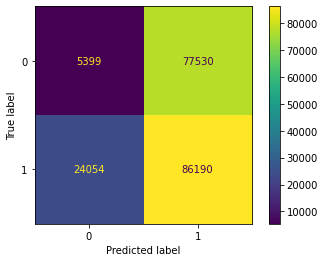

data frame  1



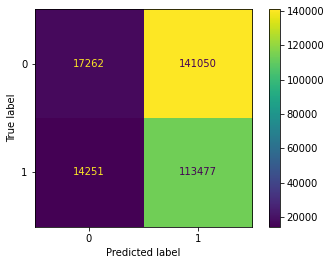

data frame  2



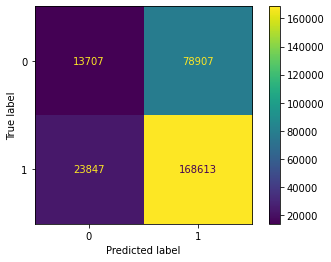

In [ ]:
#Confusion Matrix

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 
  print()
  
  cm = confusion_matrix(df[i]['predicted_value'], df[i]['True_value'], labels=[0,1])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
  disp.plot()
  plt.show()

In [ ]:
# Precision

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 
  print("Precision Score for Positive class : ",precision_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=1))
  print("Precision Score for Negative class : ",precision_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=0))
  print()
  

data frame  0
Precision Score for Positive class :  0.7818112550342876
Precision Score for Negative class :  0.06510388404538822

data frame  1
Precision Score for Positive class :  0.888426969810848
Precision Score for Negative class :  0.10903784931022285

data frame  2
Precision Score for Positive class :  0.8760937337628598
Precision Score for Negative class :  0.14800138208046298



In [ ]:
# Recall

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 
  print("Precision Score for Positive class : ",recall_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=1))
  print("Precision Score for Negative class : ",recall_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=0))
  print()
  

data frame  0
Precision Score for Positive class :  0.5264475934522356
Precision Score for Negative class :  0.18330900078090517

data frame  1
Precision Score for Positive class :  0.4458348230246693
Precision Score for Negative class :  0.5477739345666868

data frame  2
Precision Score for Positive class :  0.6812095992243051
Precision Score for Negative class :  0.3649944080524045



In [ ]:
# F1 Score

for i in range(len(df)):
  df[i]['star_rating'] = df[i]['star_rating'].astype('float')
  print("data frame ", i)
  
  df[i]['predicted_value'] = df[i]['predicted_value'].astype('int') 
  df[i]['True_value'] = df[i]['True_value'].astype('int') 
  print("F1 Score for Positive class : ",f1_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=1))
  print("F1 Score for Negative class : ",f1_score(df[i]['True_value'], df[i]['predicted_value'], average='binary',pos_label=0))
  print()
  

data frame  0
F1 Score for Positive class :  0.6292067570921727
F1 Score for Negative class :  0.0960830026160773

data frame  1
F1 Score for Positive class :  0.5937240847078521
F1 Score for Negative class :  0.18187277755827735

data frame  2
F1 Score for Positive class :  0.7664575662530114
F1 Score for Negative class :  0.21060475692950648



In [ ]:
# MAP Score
for i in range(len(df)):
  print("data frame ", i)
  temp = df[i]
  temp = temp.groupby(['product_id']).mean()[['star_rating','score']]
  rank_star = temp.sort_values("star_rating",ascending=False)
  rank_score = temp.sort_values("score",ascending=False)
  print("MAP:",mapk(rank_star.index, rank_score.index,k=3))
  print()

data frame  0
MAP: 0.6666666666666666

data frame  1
MAP: 0.6656108597285068

data frame  2
MAP: 0.6666666666666666



## Visualization

In [ ]:
def top_used(text):
  global words 
  for t in text:
    words[t] += 1

word_counts = []
for i in range(len(df)):
  words = defaultdict(int)
  df[i].tokenized.apply(top_used)
  word_counts.append(words)

count_dfs = []
for i in range(len(df)): 
  key = list(word_counts[i].keys())
  value = list(word_counts[i].values())
  count_df = pd.DataFrame(list(zip(key, value)), columns=['word', 'count'])
  count_dfs.append(count_df)

cnt_class = []
for i in range(len(df)):
  tmp = count_dfs[i].merge(class_fixed[i], on='word', how='left').sort_values(by = ['class','count'],ascending = False).groupby('class').head(10)
  tmp = tmp.loc[tmp['class'].isin(['Positive','Negative'])]
  cnt_class.append(tmp)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

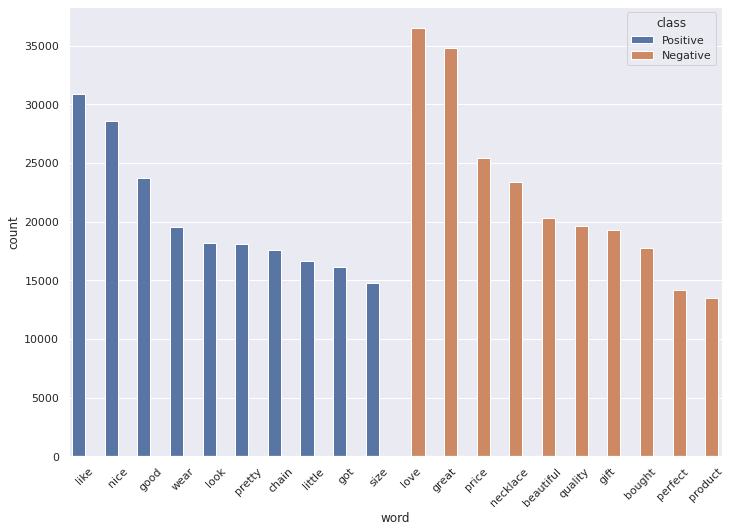

In [ ]:
sb.set_theme(style="whitegrid")
sb.set(rc={'figure.figsize':(11.7,8.27)})
ax = sb.barplot(data=cnt_class[0], x='word', y='count', hue='class')
plt.xticks(rotation=45)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

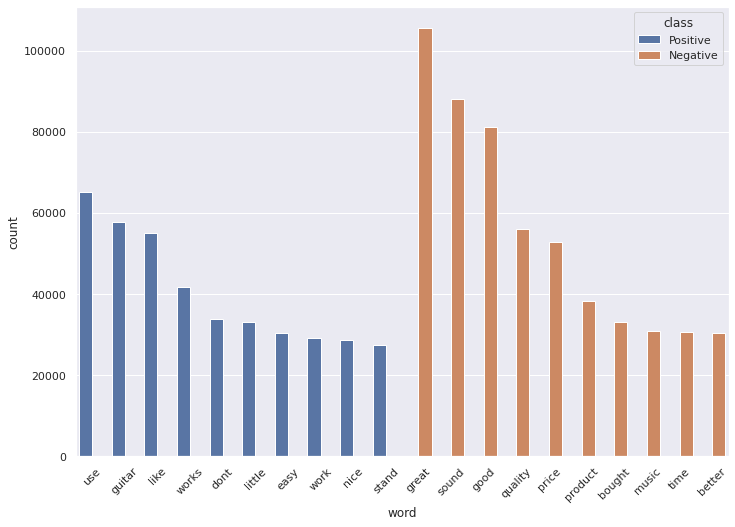

In [ ]:
ax = sb.barplot(data=cnt_class[1], x='word', y='count', hue='class')
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

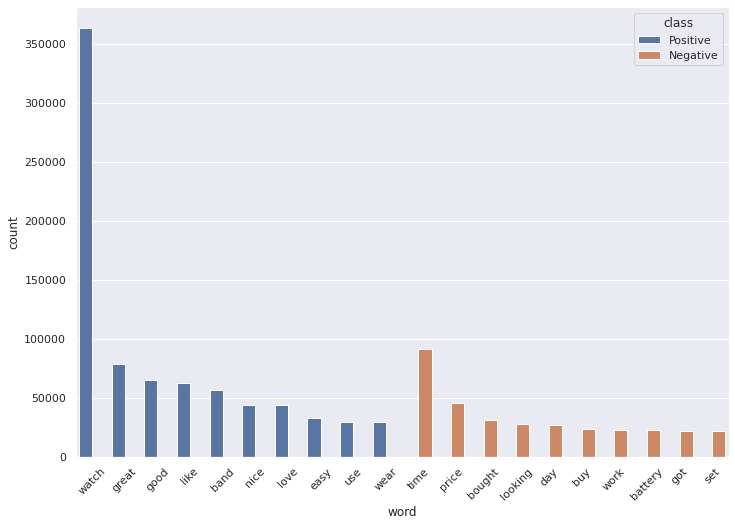

In [ ]:
ax = sb.barplot(data=cnt_class[2], x='word', y='count', hue='class')
plt.xticks(rotation=45)

## Querying

In [ ]:
def recommendation(product):
  dct = dict({'Jewelry' : 0, 'Musical Instruments': 1, 'Watches' : 2 })
  for i in dct:
    if i == 'Watches':
      tt = df[dct[i]].groupby('product_id').head(10).mean()['score']
      break
    else:
      return "Invalid Product Name"
  return tt

In [ ]:
product = input("Enter product number : ")
recommendation(product)